In [1]:
#Load libraries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import sspa
from sklearn.preprocessing import StandardScaler
import scipy 
import networkx as nx


In [2]:
#Load dataset
df = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)

### Data exploration

In [ ]:
print("Number of proteins:", len(df. columns[:-2]) )
print("Number of samples:", len(df. index))


print(df['WHO_status'].value_counts()) 
print(df['Group'].value_counts())

#return non-integer columns
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']


In [ ]:
#Check data is standardised 

df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
print(df_num.max().max())
print(df_num.min().min())
print(df_num.mean(axis = 0)) #mean of 0
print(df_num.std(axis = 0)) #sd of 1


In [ ]:
df_hist = df_num.mean(axis = 0)
sns.histplot(df_hist, bins = 50,color='#79C99E',edgecolor="k") 

#The mean value for each protein has been plotted
plt.title('Mean protein distribution',fontsize=16)
plt.xlabel('Protein expression (e-15)',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/mean_protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
df_num_np = df_num.to_numpy()

df_hist = df_num_np.flatten()
sns.histplot(df_hist, bins = 45,color='#79C99E',edgecolor="k") 

plt.title('Protein distribution',fontsize=16)
plt.xlabel('Protein expression',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#print(df.iloc[:,-5:])
df_heatmap = df.groupby('WHO_status').mean(numeric_only=True)

g = sns.clustermap(
    df_heatmap,metric='euclidean',
      method ="ward",
      row_cluster=False,
      xticklabels=False,
      cmap='RdBu_r',
      figsize=(9,3),
      dendrogram_ratio=0.2, 
      vmin=-2, 
      vmax=2) 

g2 = g.ax_heatmap
g2.set_xlabel("Proteins", fontsize = 15,labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("WHO status", fontsize = 15, labelpad=12) 
g2.set_yticklabels(g2.get_yticklabels(), rotation=0, fontsize=10)  #rotate the y-axis labels so that they are horizontal

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.28, 0.03, 0.35])
g.cax.set_title("Protein expression",pad=10, size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=10) #change font of colourbar labels; 

#plt.savefig( 'Figures/protein_heatmap.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Carry out PCA

#from sklearn.decomposition import PCA

features = df.columns[:-2]
x = df.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

display(df3)



sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA for proteins',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15,)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7)) 
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

#plt.savefig( 'Figures/proteins_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### FOR DATA INTEGRATION STEP OR IF COMPARING BY CASE SEVERITY
### Subset the data to common samples

We make two different networks, one for the COVID cases 1-2 compared to COVID cases 3-7 <br>
This is because there are only 18 samples in common between the metabolomic and proteomic datasets

0       Common samples: 18           Metabolomic samples: 133        Proteomic samples: 123 <br>
1-2       Common samples: 45          Metabolomic samples: 45        Proteomic samples: 48 <br>
3-4       Common samples: 56          Metabolomic samples: 57        Proteomic samples: 59 <br>
5-7       Common samples: 27          Metabolomic samples: 28        Proteomic samples: 28 <br>

146 common samples overall,   128 cases, composed of (45 samples (WHO 1-2) vs 83 samples (WHO 3-7))

In [3]:
df2 = pd.read_csv('Data/Su_COVID_metabolomics_processed_ChEBI.csv', index_col=0)
df2.index= df2.index.str.rstrip('-BL')  #remove 'BL' label from the cases (so I can match to proteomic data)

list1 = list(df.index)
list2 = list(df2.index)

#Obtain common samples and subset accordingly
intersection = list(set(df.index.tolist()) & set(df2.index.tolist())) #set removes duplicates
intersection = [sample for sample in intersection if sample.startswith("INCOV")]
df = df[df.index.isin(intersection)]

print(len(df))

128


In [ ]:
df_mild = (df[df["WHO_status"] == '1-2']) #45 samples, no need to remove the metadata, since I do that in a later step
df_severe = (df[(df["WHO_status"] == '3-4') | (df["WHO_status"] == '5-7')]) #83 samples

### Single sample pathway analysis

In [4]:
#Load in a file downloaded from https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = 'Data/UniProt2Reactome_all_Levels.txt', download_latest = False, filepath = None)
kpca_scores = sspa.sspa_kpca(df.iloc[:,:-2], reactome_pathways)

In [5]:
#Remove root pathways
#Convert pathway ID to name
root_path = pd.read_excel('Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Using Sara's code
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns)))

In [ ]:
kpca_scores

### kPCA figures

In [ ]:

kpca_hist = kpca_scores.to_numpy()
kpca_hist = kpca_hist.flatten()
sns.histplot(kpca_hist, bins = 40,color='#F7C3B1',edgecolor="k") 

plt.title('Protein pathway score distribution',fontsize=16)
plt.xlabel('Pathway score',fontsize=13, labelpad=5)
plt.ylabel('Frequency',fontsize=13, labelpad=10) ;

#plt.savefig( 'Figures/protein_pathway_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Carry out PCA

#from sklearn.decomposition import PCA

features = kpca_scores.columns
x = kpca_scores.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

#display(df3)


sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, 
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA kPCA protein scores',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7))
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
#plt.savefig( 'Figures/protein_kPCA_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



In [ ]:
#Normalise pathway scores : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(kpca_scores),columns=kpca_scores.columns, index=kpca_scores.index)


kpca_hist = kpca_scores_norm.to_numpy()
kpca_hist = kpca_hist.flatten()
sns.histplot(kpca_hist, bins = 40,color='#F7C3B1',edgecolor="k") 

plt.title('Normalised protein pathway score distribution',fontsize=16)
plt.xlabel('Pathway score',fontsize=13, labelpad=5)
plt.ylabel('Frequency',fontsize=13, labelpad=10) ;

#plt.savefig( 'Figures/normalised_protein_pathway_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Carry out PCA on NORMALISED values

#from sklearn.decomposition import PCA

features = kpca_scores_norm.columns
x = kpca_scores_norm.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

#display(df3)


sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, 
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA kPCA normalised protein scores',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7))
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
#plt.savefig( 'Figures/normalised_protein_kPCA_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



### Spearman correlation coefficient

In [6]:
#Note: Spearman correlation coefficient results are the same whether or not the kPCA scores are normalised

#"If axis=0 (default), then each column represents a variable, with observations in the rows"
spearman_results = scipy.stats.spearmanr(kpca_scores)

spearman_coef = spearman_results[0] #correlation coefficients
spearman_pvals = spearman_results[1] #p-values


#Using Sara's code (rather than having separate dataframes for each analysis, add all together in long format)
squared_spearman_coef_df = pd.DataFrame(spearman_coef,columns = kpca_scores.columns, index=kpca_scores.columns)
squared_spearman_coef_list = squared_spearman_coef_df.stack().reset_index()
squared_spearman_coef_list.columns = ["Pathway1", "Pathway2", "Spearman_corr"]
squared_spearman_coef_list["Squared_corr"]  = np.square(squared_spearman_coef_list.Spearman_corr)

spearman_pvals_df = pd.DataFrame(spearman_pvals,columns = kpca_scores.columns, index=kpca_scores.columns)
spearman_pvals_list = spearman_pvals_df.stack().reset_index()
spearman_pvals_list.columns = ["Pathway1", "Pathway2", "pval"]

#Multiple testing correction for the p-values to prepare the corrected p-values for the final correlation network
#Multiplies by the correct number of tests (i.e. not including the duplicates or self-comparisons)
#Does not remove the diagonals or the duplicates themselves
num_of_tests = (len(kpca_scores.columns)**2 - len(kpca_scores.columns))/2
print(num_of_tests)
corrected_spearman_pvals = spearman_pvals_list.pval*num_of_tests
#If the p-val goes beyond 1 (max number for a p-value, change to 1)
corrected_spearman_pvals = np.where(corrected_spearman_pvals < 1, corrected_spearman_pvals, 1)
spearman_pvals_list["pval_adj"]  = corrected_spearman_pvals

spearman_df = squared_spearman_coef_list.merge(spearman_pvals_list,on=["Pathway1","Pathway2"])

display(spearman_df)

166753.0


,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj
0,R-HSA-109581,R-HSA-109581,1.000000,1.000000,0.000000e+00,0.000000e+00
1,R-HSA-109581,R-HSA-109606,0.832420,0.692922,4.223619e-34,7.043011e-29
2,R-HSA-109581,R-HSA-109704,0.598477,0.358174,8.614639e-14,1.436517e-08
3,R-HSA-109581,R-HSA-110362,-0.124096,0.015400,1.628312e-01,1.000000e+00
4,R-HSA-109581,R-HSA-110373,-0.124096,0.015400,1.628312e-01,1.000000e+00
...,...,...,...,...,...,...
334079,R-HSA-983705,R-HSA-983168,0.608159,0.369857,2.666379e-14,4.446267e-09
334080,R-HSA-983705,R-HSA-983169,0.805227,0.648390,2.213046e-30,3.690321e-25
334081,R-HSA-983705,R-HSA-983231,-0.718830,0.516717,1.246979e-21,2.079376e-16
334082,R-HSA-983705,R-HSA-983695,0.884099,0.781630,1.873109e-43,3.123466e-38


In [7]:
#Perform multiple testing correlation on p-values after the duplicates are removed

#https://tedboy.github.io/statsmodels_doc/generated/statsmodels.stats.multitest.multipletests.html#statsmodels.stats.multitest.multipletests

#All self-comparisons are significant with a p-value of 0, so we can subtract those from the number of significant values before we divide by 2
sig_vals = (sum(i < 0.005 for i in spearman_df.pval_adj)-len(kpca_scores.columns))   /2
non_sig_vals = sum(i >= 0.005 for i in spearman_df.pval_adj)/2

print("Number of significant values:", sig_vals)
print("Number of non-significant values:", non_sig_vals)
(sig_vals/(sig_vals+non_sig_vals)) * 100

Number of significant values: 85187.0
Number of non-significant values: 81566.0


51.085737587929444

In [ ]:
squared_spearman_coef = np.square(spearman_coef)
abs_spearman_coef = np.abs(spearman_coef)

#Mask the upper half of the dataframe (so I don't view the comparisons between the two same genes, and also the duplicate comparisons are removed)
mask =  squared_spearman_coef.copy()
mask = np.triu(np.ones(mask.shape)).astype(bool)
mask = np.invert(mask) #invert true and false values so the diagonal is False as well
non_dup_squared_spearman_coef = pd.DataFrame(squared_spearman_coef)
non_dup_squared_spearman_coef = non_dup_squared_spearman_coef.where(mask) #Replace all false values with NaN using mask
#display(non_dup_squared_spearman_coef)
#display(pd.DataFrame(squared_spearman_coef))

spearman_hist = non_dup_squared_spearman_coef.to_numpy().flatten()
spearman_hist = spearman_hist[~np.isnan(spearman_hist)] #remove nan values
print(len(spearman_hist))
#spearman_hist = squared_spearman_coef.to_numpy().flatten()
sns.histplot(spearman_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Correlation score',fontsize=16, labelpad=5)
plt.ylabel('Frequency',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/protein_spearman_correlation_distribution_squared_non_dup.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:

#The reason for plotting as absolute or squared is that kPCA does not determine the directionality of effect
#Therefore the direction specified here is arbitrary i.e. negative pathway score does not mean downregulation of pathway


g = sns.clustermap(
    squared_spearman_coef,
    metric='euclidean', 
    method ="ward",
    cmap="OrRd",
    xticklabels=False, 
    yticklabels=False,
    figsize=(6,6),
    dendrogram_ratio=0.15, 
    vmin=0, 
    vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.1, 0.25, 0.03, 0.35])
g.cax.set_title("Correlation score",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font of colourbar labels; 

#plt.savefig( 'Figures/squared_protein_spearman.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Overlap coefficients

In [8]:

#Obtain pathways and corresponding proteins, store as dictionary
orig_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

#Filter out dictionary to retain only the pathways that remain after kPCA
my_keys = kpca_scores.columns
pathways_dict = {key: orig_dict[key] for key in my_keys}


In [9]:
#Filter out the compounds in the pathways that are not present in the dataset

#Obtain all unique values in dataset
compounds_present = list(df.columns[:-2])
filtered_dict = {} 

#My code adapted from Cecilia's
#If the key values are not part of the compounds in dataset then remove
for key,value in pathways_dict.items():
    new_val = [item for item in value if item in compounds_present]
    if len(new_val) >= 2: #at least two compounds in the pathway
        filtered_dict[key] = new_val



In [ ]:

#Identifying all duplicate pathways from the Reactome pathway dictionary AFTER COMPOUNDS NOT IN PATHWAY REMOVED (the exact same proteins, not subsets)

proteins = list(filtered_dict.values())

from collections import Counter

c = Counter(map(tuple,proteins))
dups = [k for k,v in c.items() if v>1]
result = [list(t) for t in dups]

counter = 0
for j in result:
    value = {i for i in filtered_dict if filtered_dict[i]==j}
    if len(value)!=0:
        counter +=1
    print(value)
print(counter)

In [ ]:
#Find the pathways with the minimum and maximum number of proteins in pathways AFTER COMPOUNDS NOT IN PATHWAY REMOVED

max_len = max(proteins, key=len)
print(len(max_len))

min_len = min(proteins, key=len)
print(len(min_len))


for index in range(0,len(proteins)):
    length =  90
    value = {key for key in filtered_dict if len(filtered_dict[key])==length}
print(value)

#len(filtered_dict['R-HSA-168256'])

In [10]:
#Difference between Jaccard similarity metric and S-S Overlap Coefficient
#https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient/

#Using Overlap Coefficient formula 
#My original code is in 'Overlap_coefficient_ver83.ipynb'
#I adapted by code by looking at Cecilia's comments
oc_matrix = np.zeros((len(my_keys),len(my_keys)))    

for i in range(0,len(my_keys)):   
    list1 = filtered_dict[my_keys[i]]
    
    for j in range(0,len(my_keys)):
        list2 = filtered_dict[my_keys[j]]

        # Szymkiewicz–Simpson coefficient
        #Find intersection between two lists
        intersection = len(list(set(list1).intersection(list(set(list2)))))
        smaller_set = min(len(list1), len(list2))

        val = intersection/smaller_set
        oc_matrix[i][j] = val 
        

In [11]:
oc_df = pd.DataFrame(oc_matrix, index=filtered_dict.keys(), columns=filtered_dict.keys())
#Calculate number of edges with values above or equal to 0.5

#If looking at whole matrix (not accounting for self comparisons or duplicates)
#print(np.count_nonzero(oc_matrix >= 0.5)/(len(my_keys)*len(my_keys)))

#Subtract by number of self-comparisons divided by 2
high_overlap = (np.count_nonzero(oc_matrix >= 0.5) - len(my_keys)) / 2
unique_edges =  ((len(my_keys)*len(my_keys)) - len(my_keys)) / 2

print(high_overlap  /  unique_edges)


0.0650543018716305


In [12]:
oc_list = oc_df.stack().reset_index()
oc_list.columns = ["Pathway1", "Pathway2", "Overlap_coef"]
spearman_df = spearman_df.merge(oc_list,on=["Pathway1","Pathway2"])

display(spearman_df)

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-109581,R-HSA-109581,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
1,R-HSA-109581,R-HSA-109606,0.832420,0.692922,4.223619e-34,7.043011e-29,1.000000
2,R-HSA-109581,R-HSA-109704,0.598477,0.358174,8.614639e-14,1.436517e-08,0.000000
3,R-HSA-109581,R-HSA-110362,-0.124096,0.015400,1.628312e-01,1.000000e+00,0.000000
4,R-HSA-109581,R-HSA-110373,-0.124096,0.015400,1.628312e-01,1.000000e+00,0.000000
...,...,...,...,...,...,...,...
334079,R-HSA-983705,R-HSA-983168,0.608159,0.369857,2.666379e-14,4.446267e-09,0.250000
334080,R-HSA-983705,R-HSA-983169,0.805227,0.648390,2.213046e-30,3.690321e-25,0.333333
334081,R-HSA-983705,R-HSA-983231,-0.718830,0.516717,1.246979e-21,2.079376e-16,0.000000
334082,R-HSA-983705,R-HSA-983695,0.884099,0.781630,1.873109e-43,3.123466e-38,1.000000


In [ ]:
g = sns.clustermap(oc_matrix,
metric='euclidean', 
method ="ward",
cmap = "OrRd", 
xticklabels=False, 
yticklabels=False, 
figsize=(6,6),
dendrogram_ratio=0.2, 
vmin=-0, 
vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 
g2.set(yticklabels=[])  #remove tick labels
g2.tick_params(right=False) #remove ticks

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.25, 0.03, 0.35])
g.cax.set_title("Overlap Coefficient",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font size of colourbar labels; 

#plt.savefig( 'Figures/protein_overlap_coef.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Constructing overlap coefficient network graphs

In [13]:
#Remove self-correlations
spearman_df = spearman_df [spearman_df.Pathway1 != spearman_df.Pathway2]
spearman_df = spearman_df.reset_index(drop=True)
spearman_df

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-109581,R-HSA-109606,0.832420,0.692922,4.223619e-34,7.043011e-29,1.000000
1,R-HSA-109581,R-HSA-109704,0.598477,0.358174,8.614639e-14,1.436517e-08,0.000000
2,R-HSA-109581,R-HSA-110362,-0.124096,0.015400,1.628312e-01,1.000000e+00,0.000000
3,R-HSA-109581,R-HSA-110373,-0.124096,0.015400,1.628312e-01,1.000000e+00,0.000000
4,R-HSA-109581,R-HSA-111465,0.897443,0.805404,1.295556e-46,2.160378e-41,1.000000
...,...,...,...,...,...,...,...
333501,R-HSA-983705,R-HSA-9824446,0.825673,0.681736,4.056425e-33,6.764211e-28,0.500000
333502,R-HSA-983705,R-HSA-983168,0.608159,0.369857,2.666379e-14,4.446267e-09,0.250000
333503,R-HSA-983705,R-HSA-983169,0.805227,0.648390,2.213046e-30,3.690321e-25,0.333333
333504,R-HSA-983705,R-HSA-983231,-0.718830,0.516717,1.246979e-21,2.079376e-16,0.000000


In [ ]:

#Add the nodes
G = nx.Graph()
G.add_nodes_from(oc_df.columns)

#does not deal with duplicates i.e.  Pathway 1 to Pathway 2 and vice versa
#but it's ok, because it shows up as one edge on the network in Cytoscape

G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Overlap_coef')

nx.draw(G, with_labels = True)
print(G.number_of_edges())
print(G.number_of_nodes())
#nx.write_gml(G, "Cytoscape/proteomic_oc.gml")

### Final correlation network

In [ ]:
spearman_df

578
166753


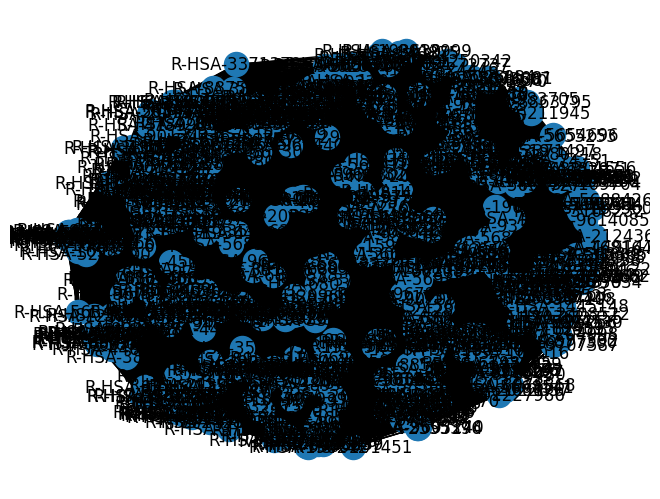

In [14]:
#MAKE A GRAPH WITH ALL THE EDGES FOR THE INTEGRATION STAGE

G = nx.Graph()
G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())


#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(spearman_df)):
    spearman_pval_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.pval_adj[i]
    overlap_coef_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.Overlap_coef[i]


nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

		
G.edges["R-HSA-109581","R-HSA-109704"]#["Spearman_pval"]

#nx.write_gml(G,'Cytoscape/proteomic_prefiltered.gml')
#nx.write_gml(G,'Cytoscape/proteomic_prefiltered_severecases.gml')

In [15]:
#Create EDGE ATTRIBUTES table to filter out unneeded edges

final_df = spearman_df[spearman_df["pval_adj"] < 0.005]  
final_df = final_df[final_df["Overlap_coef"] < 0.5]
final_df = final_df.reset_index(drop=True) 
display(final_df) #the duplicate edges have not been removed yet

#In some instances, I have nodes which have no edges, and the results are different to Sara's
#Can check the pathways prior to Overlap Coefficient filtering here
#final_df[final_df["Pathway1"] == "R-HSA-109581"]

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-109581,R-HSA-109704,0.598477,0.358174,8.614639e-14,1.436517e-08,0.000000
1,R-HSA-109581,R-HSA-112314,0.844603,0.713354,5.441458e-36,9.073794e-31,0.000000
2,R-HSA-109581,R-HSA-112315,0.853438,0.728356,1.821491e-37,3.037392e-32,0.000000
3,R-HSA-109581,R-HSA-112399,0.598477,0.358174,8.614639e-14,1.436517e-08,0.000000
4,R-HSA-109581,R-HSA-114608,0.593796,0.352593,1.497578e-13,2.497255e-08,0.000000
...,...,...,...,...,...,...,...
152359,R-HSA-983705,R-HSA-9824439,0.632039,0.399473,1.238086e-15,2.064546e-10,0.000000
152360,R-HSA-983705,R-HSA-9824443,0.550809,0.303391,1.624581e-11,2.709038e-06,0.000000
152361,R-HSA-983705,R-HSA-983168,0.608159,0.369857,2.666379e-14,4.446267e-09,0.250000
152362,R-HSA-983705,R-HSA-983169,0.805227,0.648390,2.213046e-30,3.690321e-25,0.333333


Plot spearman correlation histogram to show edges AFTER filtering

In [ ]:
#Remove duplicates in the edge list

final_df_copy = final_df.copy()

#Remove duplicate pathways
for i in range(0,len(final_df)):
    val1 = final_df.Pathway1[i]
    val2 = final_df.Pathway2[i]
    #print(val1,val2)
    #print(max(val1,val2))
    final_df_copy.Pathway1[i] = min(val1,val2)
    final_df_copy.Pathway2[i] = max(val1,val2)

final_df_copy = final_df_copy.sort_values(['Pathway1','Pathway2'], ascending=True)
final_df_copy = final_df_copy[::2]

In [ ]:
print(len(final_df_copy))
spearman_hist = list(final_df_copy.Squared_corr)
sns.histplot(spearman_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Correlation score',fontsize=16, labelpad=5)
plt.ylabel('Frequency',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/protein_spearman_correlation_distribution_squared_afterfiltering.png' , dpi=200, bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [16]:
pathways_with_edges = set(final_df.Pathway1)
isolated_nodes = set(spearman_df.Pathway1) - set(pathways_with_edges) 
isolated_nodes
#len(pathways_with_edges)

{'R-HSA-1234158',
 'R-HSA-162592',
 'R-HSA-176033',
 'R-HSA-180910',
 'R-HSA-196071',
 'R-HSA-196741',
 'R-HSA-209776',
 'R-HSA-209822',
 'R-HSA-209952',
 'R-HSA-3296469',
 'R-HSA-3296482',
 'R-HSA-3359462',
 'R-HSA-3359463',
 'R-HSA-375281',
 'R-HSA-422085',
 'R-HSA-68867',
 'R-HSA-69002',
 'R-HSA-8957322',
 'R-HSA-9020933',
 'R-HSA-9758881'}

558
76182


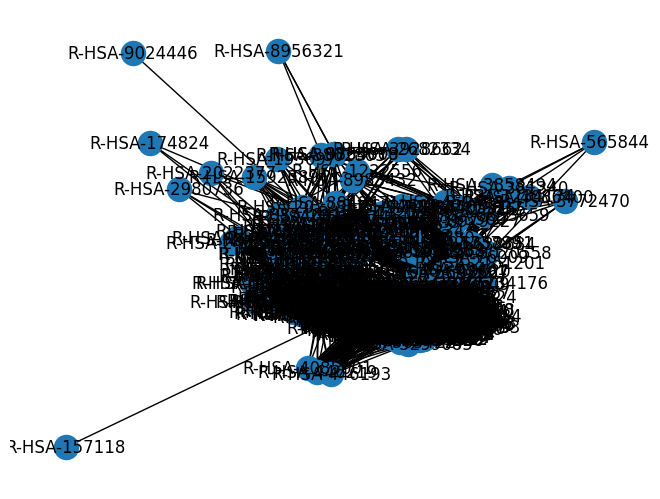

In [17]:
#Draw network graph with new edges
G = nx.Graph()
G = nx.from_pandas_edgelist(df=final_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())

In [18]:
#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(final_df)):
    spearman_pval_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.pval_adj[i]
    overlap_coef_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.Overlap_coef[i]
    
nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

#G.edges["R-HSA-109581","R-HSA-109704"]#["Spearman_pval"]


Setting node attributes

In [19]:
#IF YOU DON'T REMOVE THE EDGES, DON'T RUN THIS CODE

#Add the betweenness centrality as a node attribute
betweenness= nx.betweenness_centrality(G, normalized=True) #output as dictionary
#display(betweenness)
nx.set_node_attributes(G, betweenness, "betweenness")

#Add the betweenness centrality as a node attribute
degree= nx.degree_centrality(G) #output as dictionary
#display(degree)
nx.set_node_attributes(G, degree, "degrees")


#Check
G.nodes['R-HSA-983705']#["betweenness"]

{'betweenness': 0.0005058667555592872, 'degrees': 0.658886894075404}

Setting the highest level of the pathway hierarchy 

In [20]:
#Using Cecilia's code

#Creating graph
hierarchy = pd.read_csv('Data/ReactomePathwaysRelation.txt', sep='\t', header=None)

#From the pathways, subset to Homo sapiens only
hierarchy_hsa = hierarchy[hierarchy[0].str.contains('HSA')]

#Return unique values in the first column that is not in the second column as a numpy array
#These values are not child pathways in any instances
hierarchy_hsa_parents = np.setdiff1d(hierarchy_hsa[0], hierarchy_hsa[1])

#Add the unique values not in the second column as a second attached dataset to the bottom of the original data
#The first column represents the parent column, the second column is the child column
hierarchy_hsa_all = pd.concat([hierarchy_hsa, pd.DataFrame([hierarchy_hsa_parents, hierarchy_hsa_parents], index=[0, 1]).T])

#DiGraph is a directed graph
H = nx.from_pandas_edgelist(hierarchy_hsa, source=0, target=1, create_using=nx.DiGraph())


In [21]:
#Find the root pathway

def find_root(H,child):
    #Find parent from child 
    parent = list(H.predecessors(child))

    #Keep the loop going until the highest level is reached
    if len(parent) == 0:
        return child
    else:  
        return find_root(H, parent[0])

hierarchy_hsa_all['Root'] = [find_root(H, i) for i in hierarchy_hsa_all[1]]

hierarchy_hsa_all.columns = ['Parent', 'Child', 'Root']

#There are 83 instances of duplicates, however all the child duplicates have the same root (even though different parents) after checking

root_pathways = {}
for pathway in list(H.nodes):
    index = hierarchy_hsa_all.Child[hierarchy_hsa_all.Child == pathway].index.tolist()[0]
    root_pathway  = hierarchy_hsa_all.Root[index]
    label = root_pathway_dict[root_pathway]
    root_pathways[pathway] = label


In [22]:
#shows all the root pathways in Reactome
set(hierarchy_hsa_all['Root'] )
#shows all the root pathways present in the original dataset
set(root_pathways.values())

nx.set_node_attributes(G, root_pathways, "root_pathway")

print(G.number_of_nodes()) 

558


In [23]:
louvain_clusters = nx.community.louvain_communities(G, weight='Spearman_coef',seed=100,resolution=1.005)
print(len(louvain_clusters))

louvain_dict = {}
for index,grouping in enumerate(louvain_clusters):
    for pathway in grouping:
        louvain_dict[pathway] = index+1

nx.set_node_attributes(G, louvain_dict, "louvain")
    

3


In [24]:
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = 'Data/UniProt2Reactome_all_Levels.txt', download_latest = False, filepath = None)

pathway_name_dict = {reactome_pathways.index[i]:reactome_pathways["Pathway_name"][i] for i in range(0,len(reactome_pathways))}
pathway_name_dict = {k:pathway_name_dict[k] for k in list(G.nodes)}

nx.set_node_attributes(G, pathway_name_dict, "pathway_name")

In [25]:
print(G.number_of_nodes())
print(G.number_of_edges())

print(G.edges["R-HSA-109581","R-HSA-109704"])#["Spearman_pval"]
print(G.nodes['R-HSA-109581'])#["betweenness"]


558
76182
{'Squared_corr': 0.3581743585360057, 'Spearman_pval': 1.4365168198762704e-08, 'Overlap_coef': 0.0}
{'betweenness': 0.0009284442274120915, 'degrees': 0.6840215439856374, 'root_pathway': 'Programmed Cell Death', 'louvain': 3, 'pathway_name': 'Apoptosis'}


In [26]:
#nx.write_gml(G,'Cytoscape/proteomic_final.gml')
#nx.write_gml(G,'Cytoscape/proteomic_final_severecases.gml')